In [1]:
from pathlib import Path
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import IsolationForest
from umap import UMAP
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import hdbscan
from datetime import datetime

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/pyth

In [2]:
!pwd

/Users/adityabehal/Documents/RPI/Junior/Summer/UCSF/Shirvalkar-Lab/clustering


In [3]:
pt_id = "RCS02"

In [4]:
IMAGES_PATH = Path() / "data" / pt_id
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
pt_pain_path = Path() / "data" / pt_id / (pt_id + "_pain_filtered.xlsx")
pt_sleep_path = Path() / "data" / pt_id / (pt_id + "_sleepStageLogInfo_20190130_20230530.csv")
pt_wear_path = Path() / "data" / pt_id / (pt_id + "_fitbitWearTimeViaHR_20190130_20230530.csv")

pt_pain = pd.read_excel(pt_pain_path)
pt_sleep = pd.read_csv(pt_sleep_path)
pt_wear = pd.read_csv(pt_wear_path)

In [6]:
# convert a StartTime to a relative start time (see the cell below)
def convert_to_fractional_time(time_string):
    time_parts = time_string.split(' ')[-2].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    am_pm = time_string.split(' ')[-1].strip().upper()

    if am_pm == 'PM' and hours != 12:
        hours += 12
    elif am_pm == 'AM' and hours == 12:
        hours = 0

    fractional_hours = hours + (minutes / 60.0) + (seconds / 3600.0)

    if fractional_hours >= 24:
        fractional_hours -= 24

    return fractional_hours

In [7]:
# extract just the Day from the StartTime field and store it in a separate column
pt_sleep["Day"] = pt_sleep["StartTime"].str.split().str[0]

# binarize SleepDataType --> classic = 0, stages = 1
pt_sleep["SleepDTBinary"] = LabelEncoder().fit_transform(pt_sleep["SleepDataType"])

# we'll also convert times in StartTime to relative start times 
# (i.e. ignore the day and just look at the HH:MM:SS AM/PM and convert it into a number ranging from 0 - 24 hours)
pt_sleep["RelativeStartTime"] = pt_sleep["StartTime"].apply(convert_to_fractional_time)

# get rid of days with 0 perrcent wear time
pt_wear = pt_wear[pt_wear["PercentageWearTime"] != 0]

# merge sleep and wear dataframes with SQL-like inner join
pt_sleep_wear = pd.merge(pt_sleep, pt_wear, on="Day", how="inner")

# shorten some column names to improve plotting aesthetics 
pt_sleep_wear.columns = pt_sleep_wear.columns.str.replace("Classic", "C-")
pt_sleep_wear.columns = pt_sleep_wear.columns.str.replace("Stages", "S-")

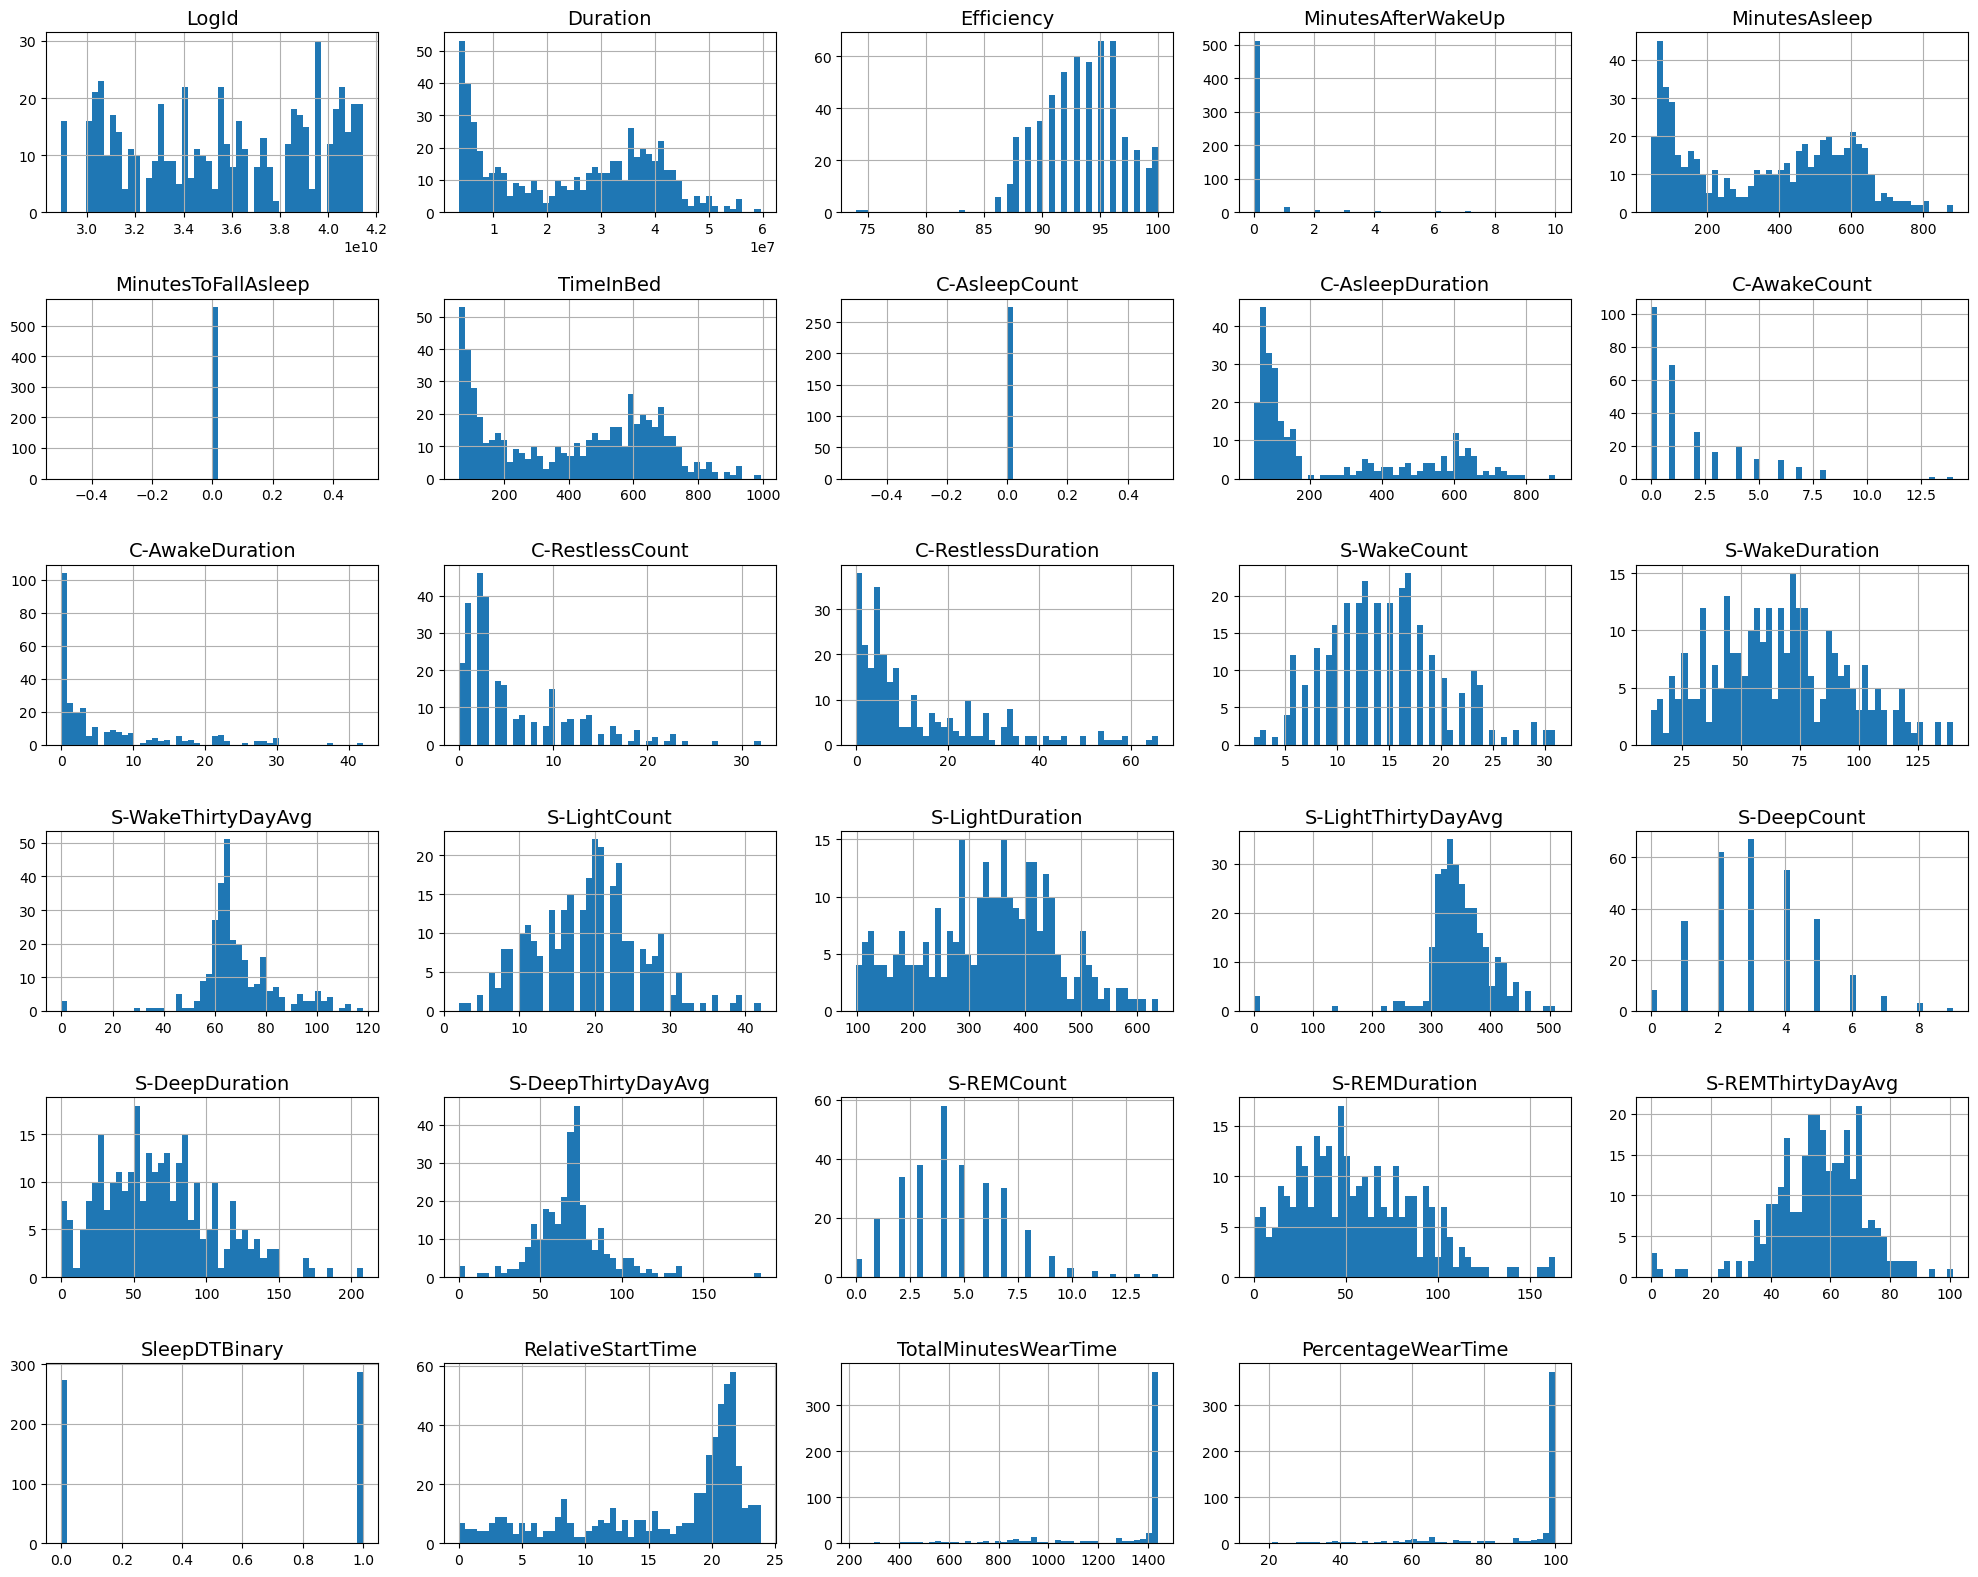

In [8]:
# the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# let's get histograms of the data variables
pt_sleep_wear.hist(bins=50, figsize=(20, 16))
plt.tight_layout()
save_fig((pt_id + "_sleep_histogram_plots"))
plt.show()

In [9]:
# let's get a sense of the number and data types of the dataframe columns
pt_sleep_wear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LogId                 561 non-null    int64  
 1   StartTime             561 non-null    object 
 2   Duration              561 non-null    int64  
 3   Efficiency            561 non-null    int64  
 4   IsMainSleep           561 non-null    bool   
 5   SleepDataType         561 non-null    object 
 6   MinutesAfterWakeUp    561 non-null    int64  
 7   MinutesAsleep         561 non-null    int64  
 8   MinutesToFallAsleep   561 non-null    int64  
 9   TimeInBed             561 non-null    int64  
 10  C-AsleepCount         274 non-null    float64
 11  C-AsleepDuration      274 non-null    float64
 12  C-AwakeCount          274 non-null    float64
 13  C-AwakeDuration       274 non-null    float64
 14  C-RestlessCount       274 non-null    float64
 15  C-RestlessDuration    2

In [10]:
# we'll consider data as reliable if the wear time for that day was more than 80 percent and if it was auto-detected
pt_sleep_wear = pt_sleep_wear[pt_sleep_wear["PercentageWearTime"] >= 80]
pt_sleep_wear = pt_sleep_wear[pt_sleep_wear["SleepLogType"] == "auto_detected"]

In [11]:
# let's get a sense of our filtered data by looking at the first 5 rows
pt_sleep_wear.head()

LogId             StartTime  Duration  Efficiency  IsMainSleep  \
360  37870822909   8/2/2022 8:59:30 PM  21720000          97         True   
361  38278802920  8/31/2022 6:43:00 AM   3780000          89         True   
362  38278802921  8/31/2022 9:31:00 PM  38700000          93         True   
363  38278802922  9/1/2022 12:02:30 PM   4500000          96        False   
364  38278802923  9/1/2022 10:14:30 PM  40800000          90         True   

    SleepDataType  MinutesAfterWakeUp  MinutesAsleep  MinutesToFallAsleep  \
360        stages                   0            317                    0   
361       classic                   0             56                    0   
362       classic                   0            599                    0   
363       classic                   0             72                    0   
364        stages                   0            585                    0   

     TimeInBed  ...  S-DeepThirtyDayAvg  S-REMCount  S-REMDuration  \
360        362  ...                78.0         3.0           40.0   
361         63  ...                 NaN         NaN            NaN   
362        645  ...                 NaN         NaN            NaN   
363         75  ...                 NaN         NaN            NaN   
364        680  ...                53.0         7.0           74.0   

     S-REMThirtyDayAvg   SleepLogType        Day  SleepDTBinary  \
360               84.0  auto_detected   8/2/2022              1   
361                NaN  auto_detected  8/31/2022              0   
362                NaN  auto_detected  8/31/2022              0   
363                NaN  auto_detected   9/1/2022              0   
364               40.0  auto_detected   9/1/2022              1   

     RelativeStartTime  TotalMinutesWearTime  PercentageWearTime  
360          20.991667                  1440          100.000000  
361           6.716667                  1428           99.166667  
362          21.516667                  1428           99.166667  
363          12.041667                  1440          100.000000  
364          22.241667                  1440          100.000000  

[5 rows x 34 columns]

In [12]:
# let's get a sense of the number and data types of the filtered dataframe columns
pt_sleep_wear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 360 to 559
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LogId                 182 non-null    int64  
 1   StartTime             182 non-null    object 
 2   Duration              182 non-null    int64  
 3   Efficiency            182 non-null    int64  
 4   IsMainSleep           182 non-null    bool   
 5   SleepDataType         182 non-null    object 
 6   MinutesAfterWakeUp    182 non-null    int64  
 7   MinutesAsleep         182 non-null    int64  
 8   MinutesToFallAsleep   182 non-null    int64  
 9   TimeInBed             182 non-null    int64  
 10  C-AsleepCount         78 non-null     float64
 11  C-AsleepDuration      78 non-null     float64
 12  C-AwakeCount          78 non-null     float64
 13  C-AwakeDuration       78 non-null     float64
 14  C-RestlessCount       78 non-null     float64
 15  C-RestlessDuration   

In [13]:
# let's get summary statistics of the filtered dataframe columns
pt_sleep_wear.describe()

LogId      Duration  Efficiency  MinutesAfterWakeUp  \
count  1.820000e+02  1.820000e+02  182.000000          182.000000   
mean   3.986713e+10  2.480802e+07   94.010989            0.291209   
std    1.004853e+09  1.470739e+07    3.454501            1.192902   
min    3.787082e+10  3.600000e+06   83.000000            0.000000   
25%    3.890472e+10  9.630000e+06   92.000000            0.000000   
50%    3.969035e+10  2.805000e+07   94.000000            0.000000   
75%    4.067480e+10  3.774000e+07   96.000000            0.000000   
max    4.145769e+10  5.550000e+07  100.000000            9.000000   

       MinutesAsleep  MinutesToFallAsleep   TimeInBed  C-AsleepCount  \
count     182.000000                182.0  182.000000           78.0   
mean      370.000000                  0.0  413.467033            0.0   
std       217.853364                  0.0  245.123188            0.0   
min        53.000000                  0.0   60.000000            0.0   
25%       149.250000                  0.0  160.500000            0.0   
50%       415.500000                  0.0  467.500000            0.0   
75%       550.500000                  0.0  629.000000            0.0   
max       882.000000                  0.0  925.000000            0.0   

       C-AsleepDuration  C-AwakeCount  ...  S-DeepCount  S-DeepDuration  \
count         78.000000     78.000000  ...   104.000000      104.000000   
mean         261.294872      1.782051  ...     3.269231       69.836538   
std          248.593295      2.500117  ...     1.730541       37.642702   
min           53.000000      0.000000  ...     0.000000        0.000000   
25%           76.000000      0.000000  ...     2.000000       40.750000   
50%          113.000000      1.000000  ...     3.000000       66.000000   
75%          513.000000      2.750000  ...     4.000000       96.250000   
max          882.000000     14.000000  ...     8.000000      169.000000   

       S-DeepThirtyDayAvg  S-REMCount  S-REMDuration  S-REMThirtyDayAvg  \
count          104.000000  104.000000     104.000000         104.000000   
mean            70.769231    4.538462      56.826923          57.076923   
std             10.918258    2.364474      30.991212          10.189174   
min             43.000000    0.000000       0.000000          29.000000   
25%             65.750000    3.000000      33.750000          52.000000   
50%             71.000000    4.000000      54.000000          58.000000   
75%             74.250000    6.000000      81.250000          65.000000   
max            102.000000   11.000000     143.000000          84.000000   

       SleepDTBinary  RelativeStartTime  TotalMinutesWearTime  \
count     182.000000         182.000000            182.000000   
mean        0.571429          16.243819           1418.005495   
std         0.496237           6.689145             54.075198   
min         0.000000           0.233333           1168.000000   
25%         0.000000          11.985417           1425.500000   
50%         1.000000          19.575000           1440.000000   
75%         1.000000          21.241667           1440.000000   
max         1.000000          23.800000           1440.000000   

       PercentageWearTime  
count          182.000000  
mean            98.472604  
std              3.755222  
min             81.111111  
25%             98.993056  
50%            100.000000  
75%            100.000000  
max            100.000000  

[8 rows x 29 columns]

In [14]:
# code adapted from https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another
# we will use kendall tau rank correlation as it more robust to outliers than spearman's rank correlation

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'kendall')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.kendalltau(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=70)
    
def plotcorr(data):
    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(data, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_upper(corrdot)
    g.map_upper(corrfunc)

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

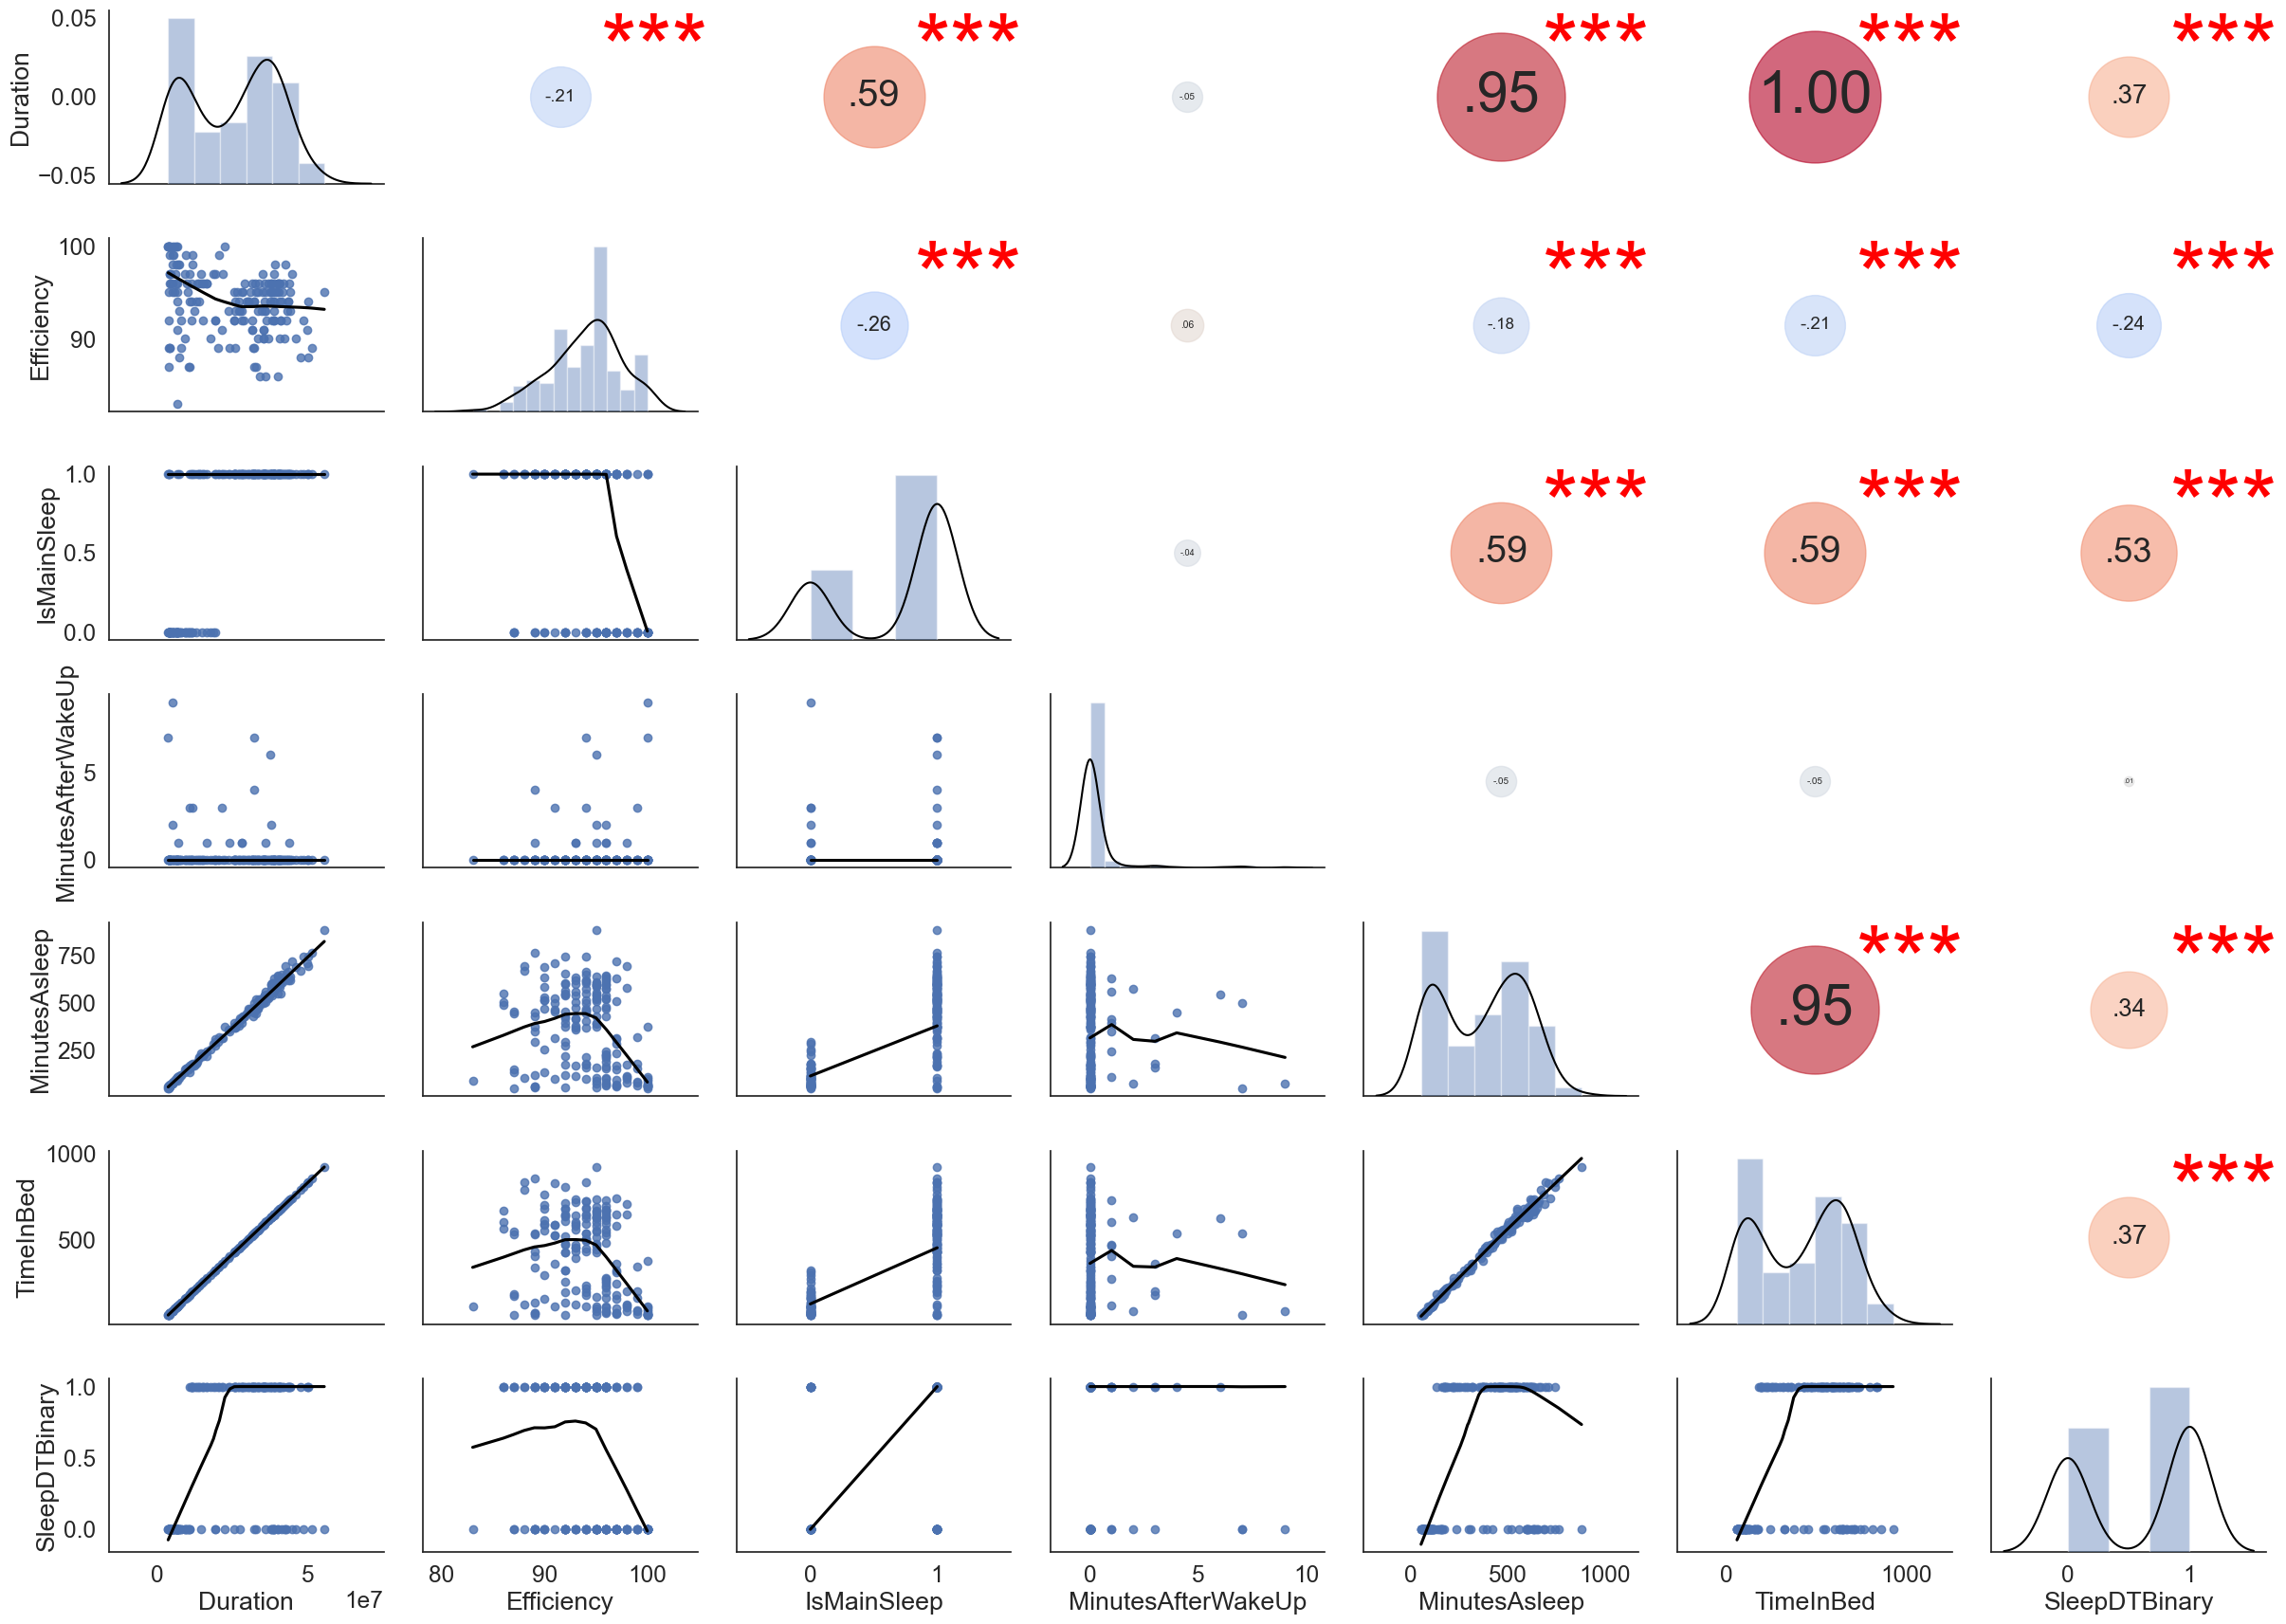

In [15]:
# let's see how well pairwise combinations of general features correlate with each other
pt_sleep_wear_scatter_all = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 30]]

plotcorr(pt_sleep_wear_scatter_all)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_all"))

plt.show()

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

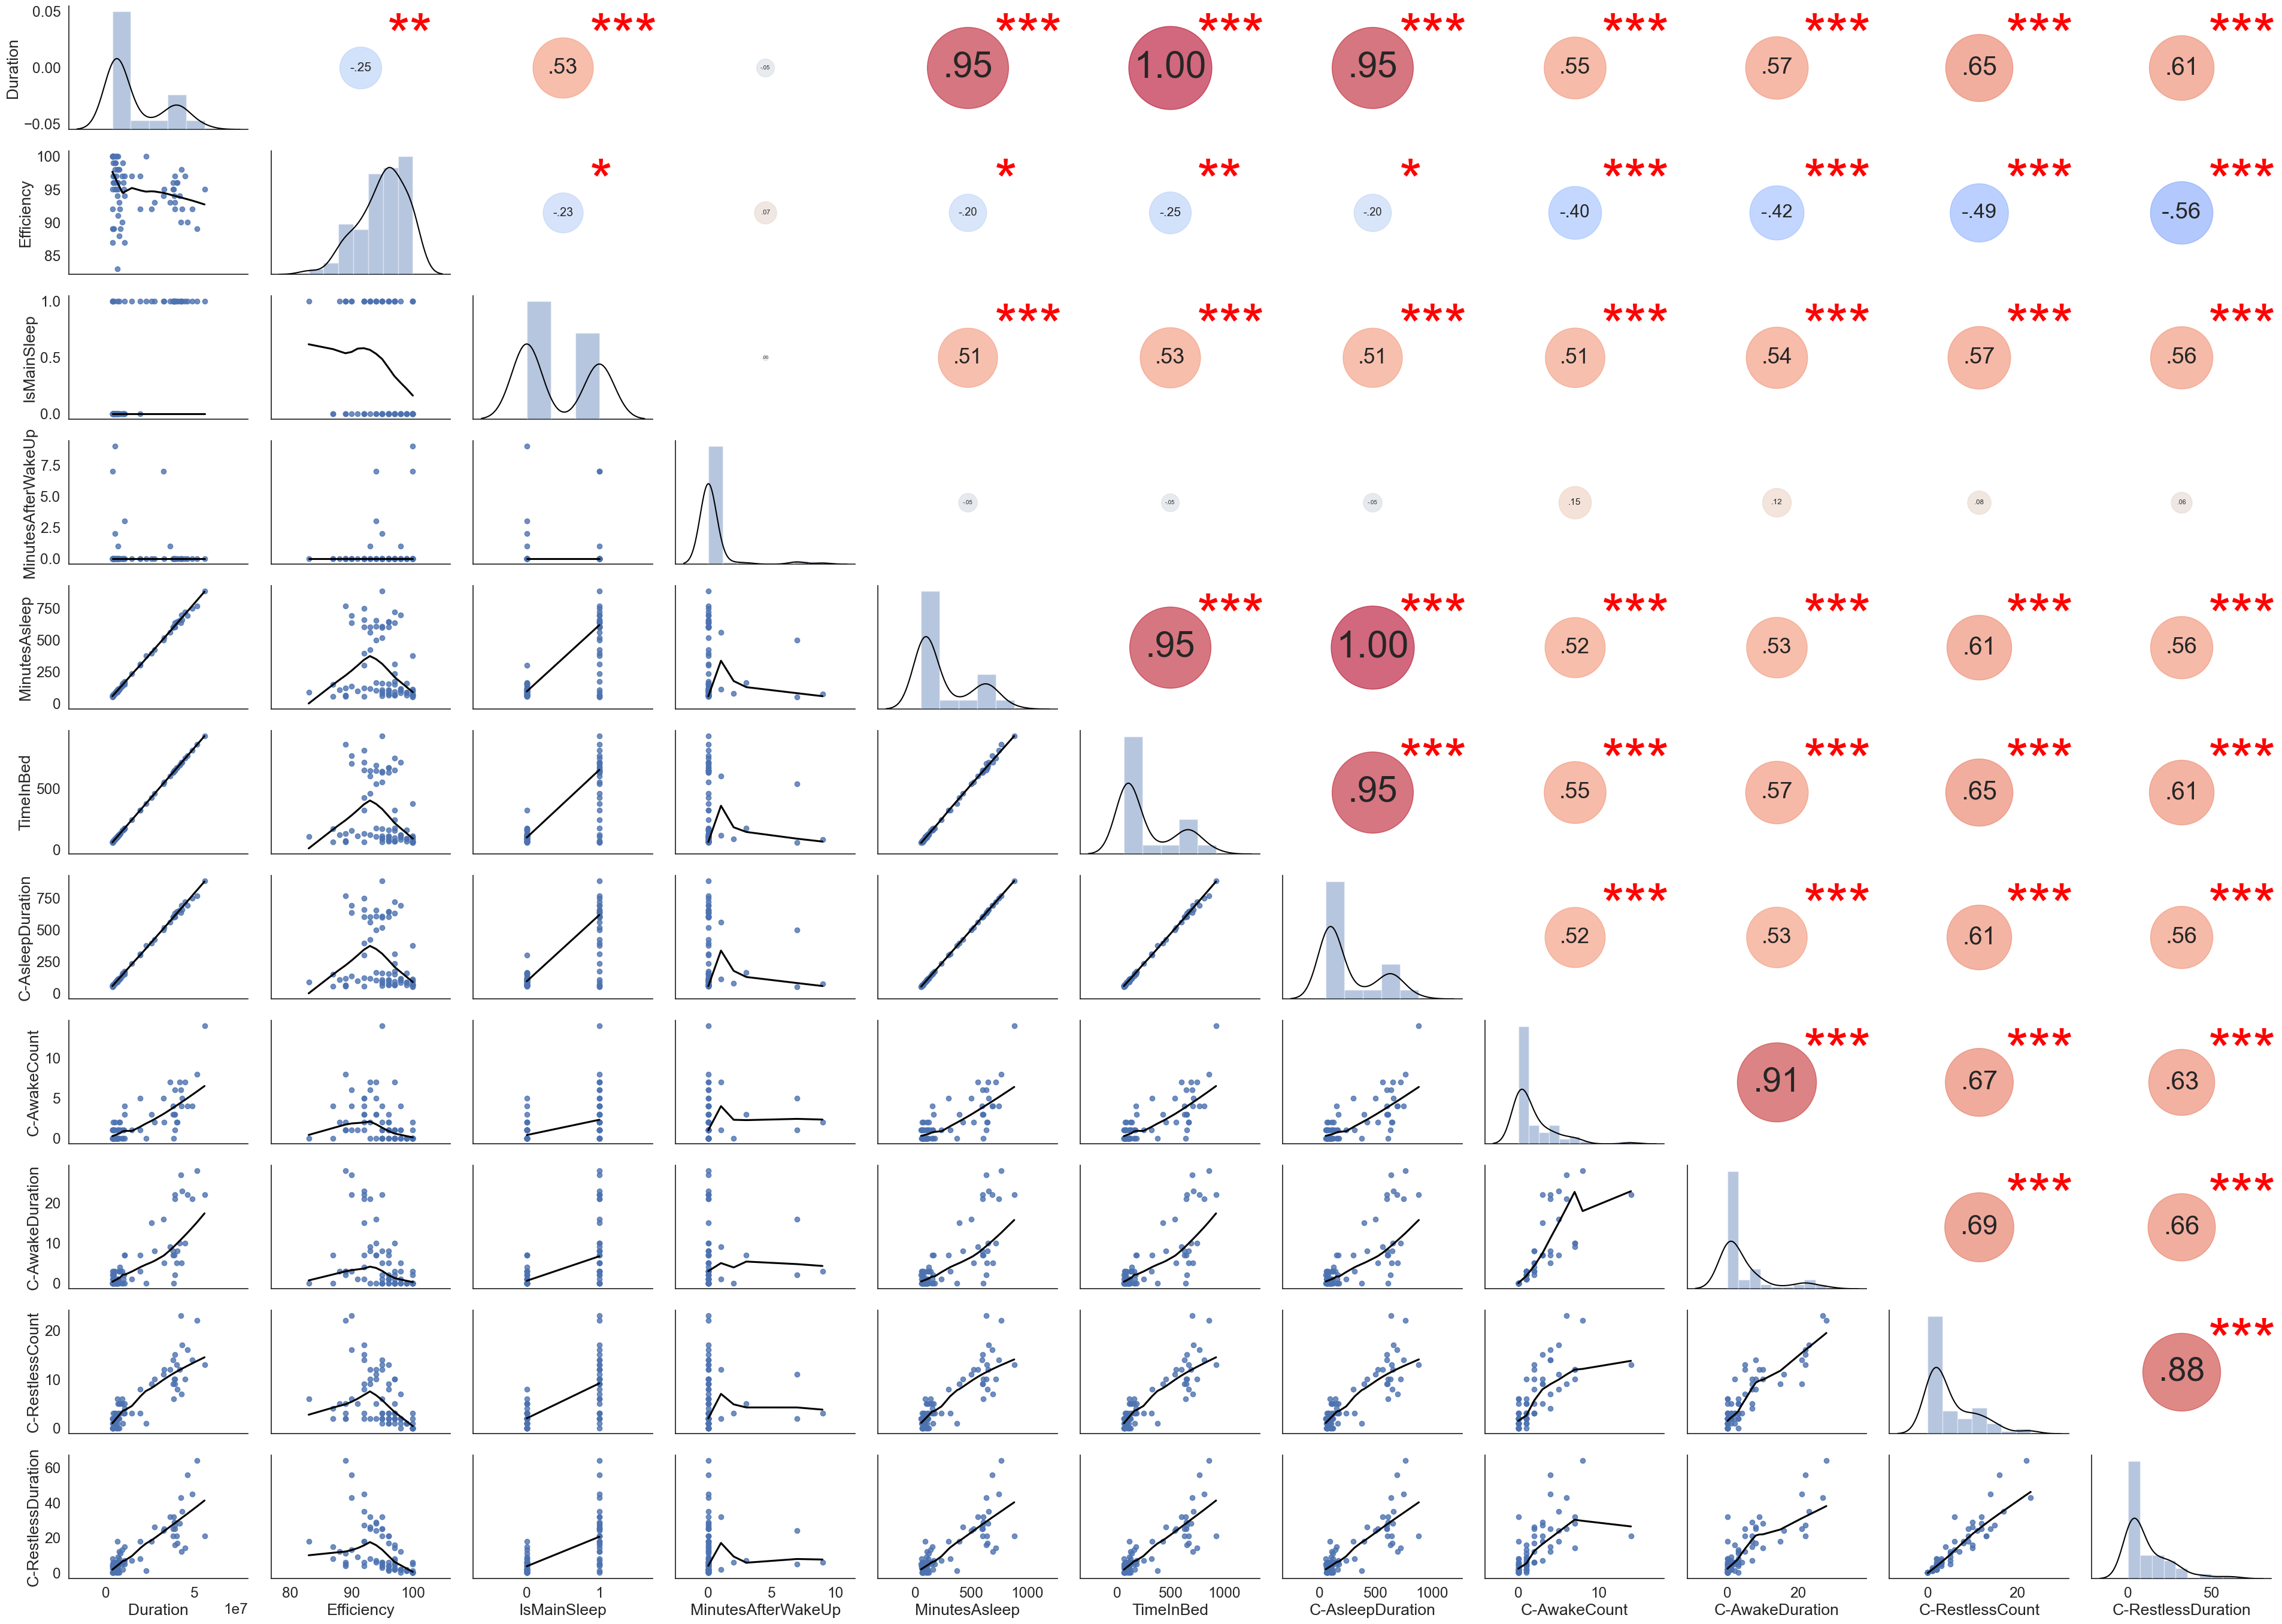

In [16]:
# let's see how well pairwise combinations of classic features correlate with each other
pt_sleep_wear_scatter_classic = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15]].dropna()

plotcorr(pt_sleep_wear_scatter_classic)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_classic"))

plt.show()

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

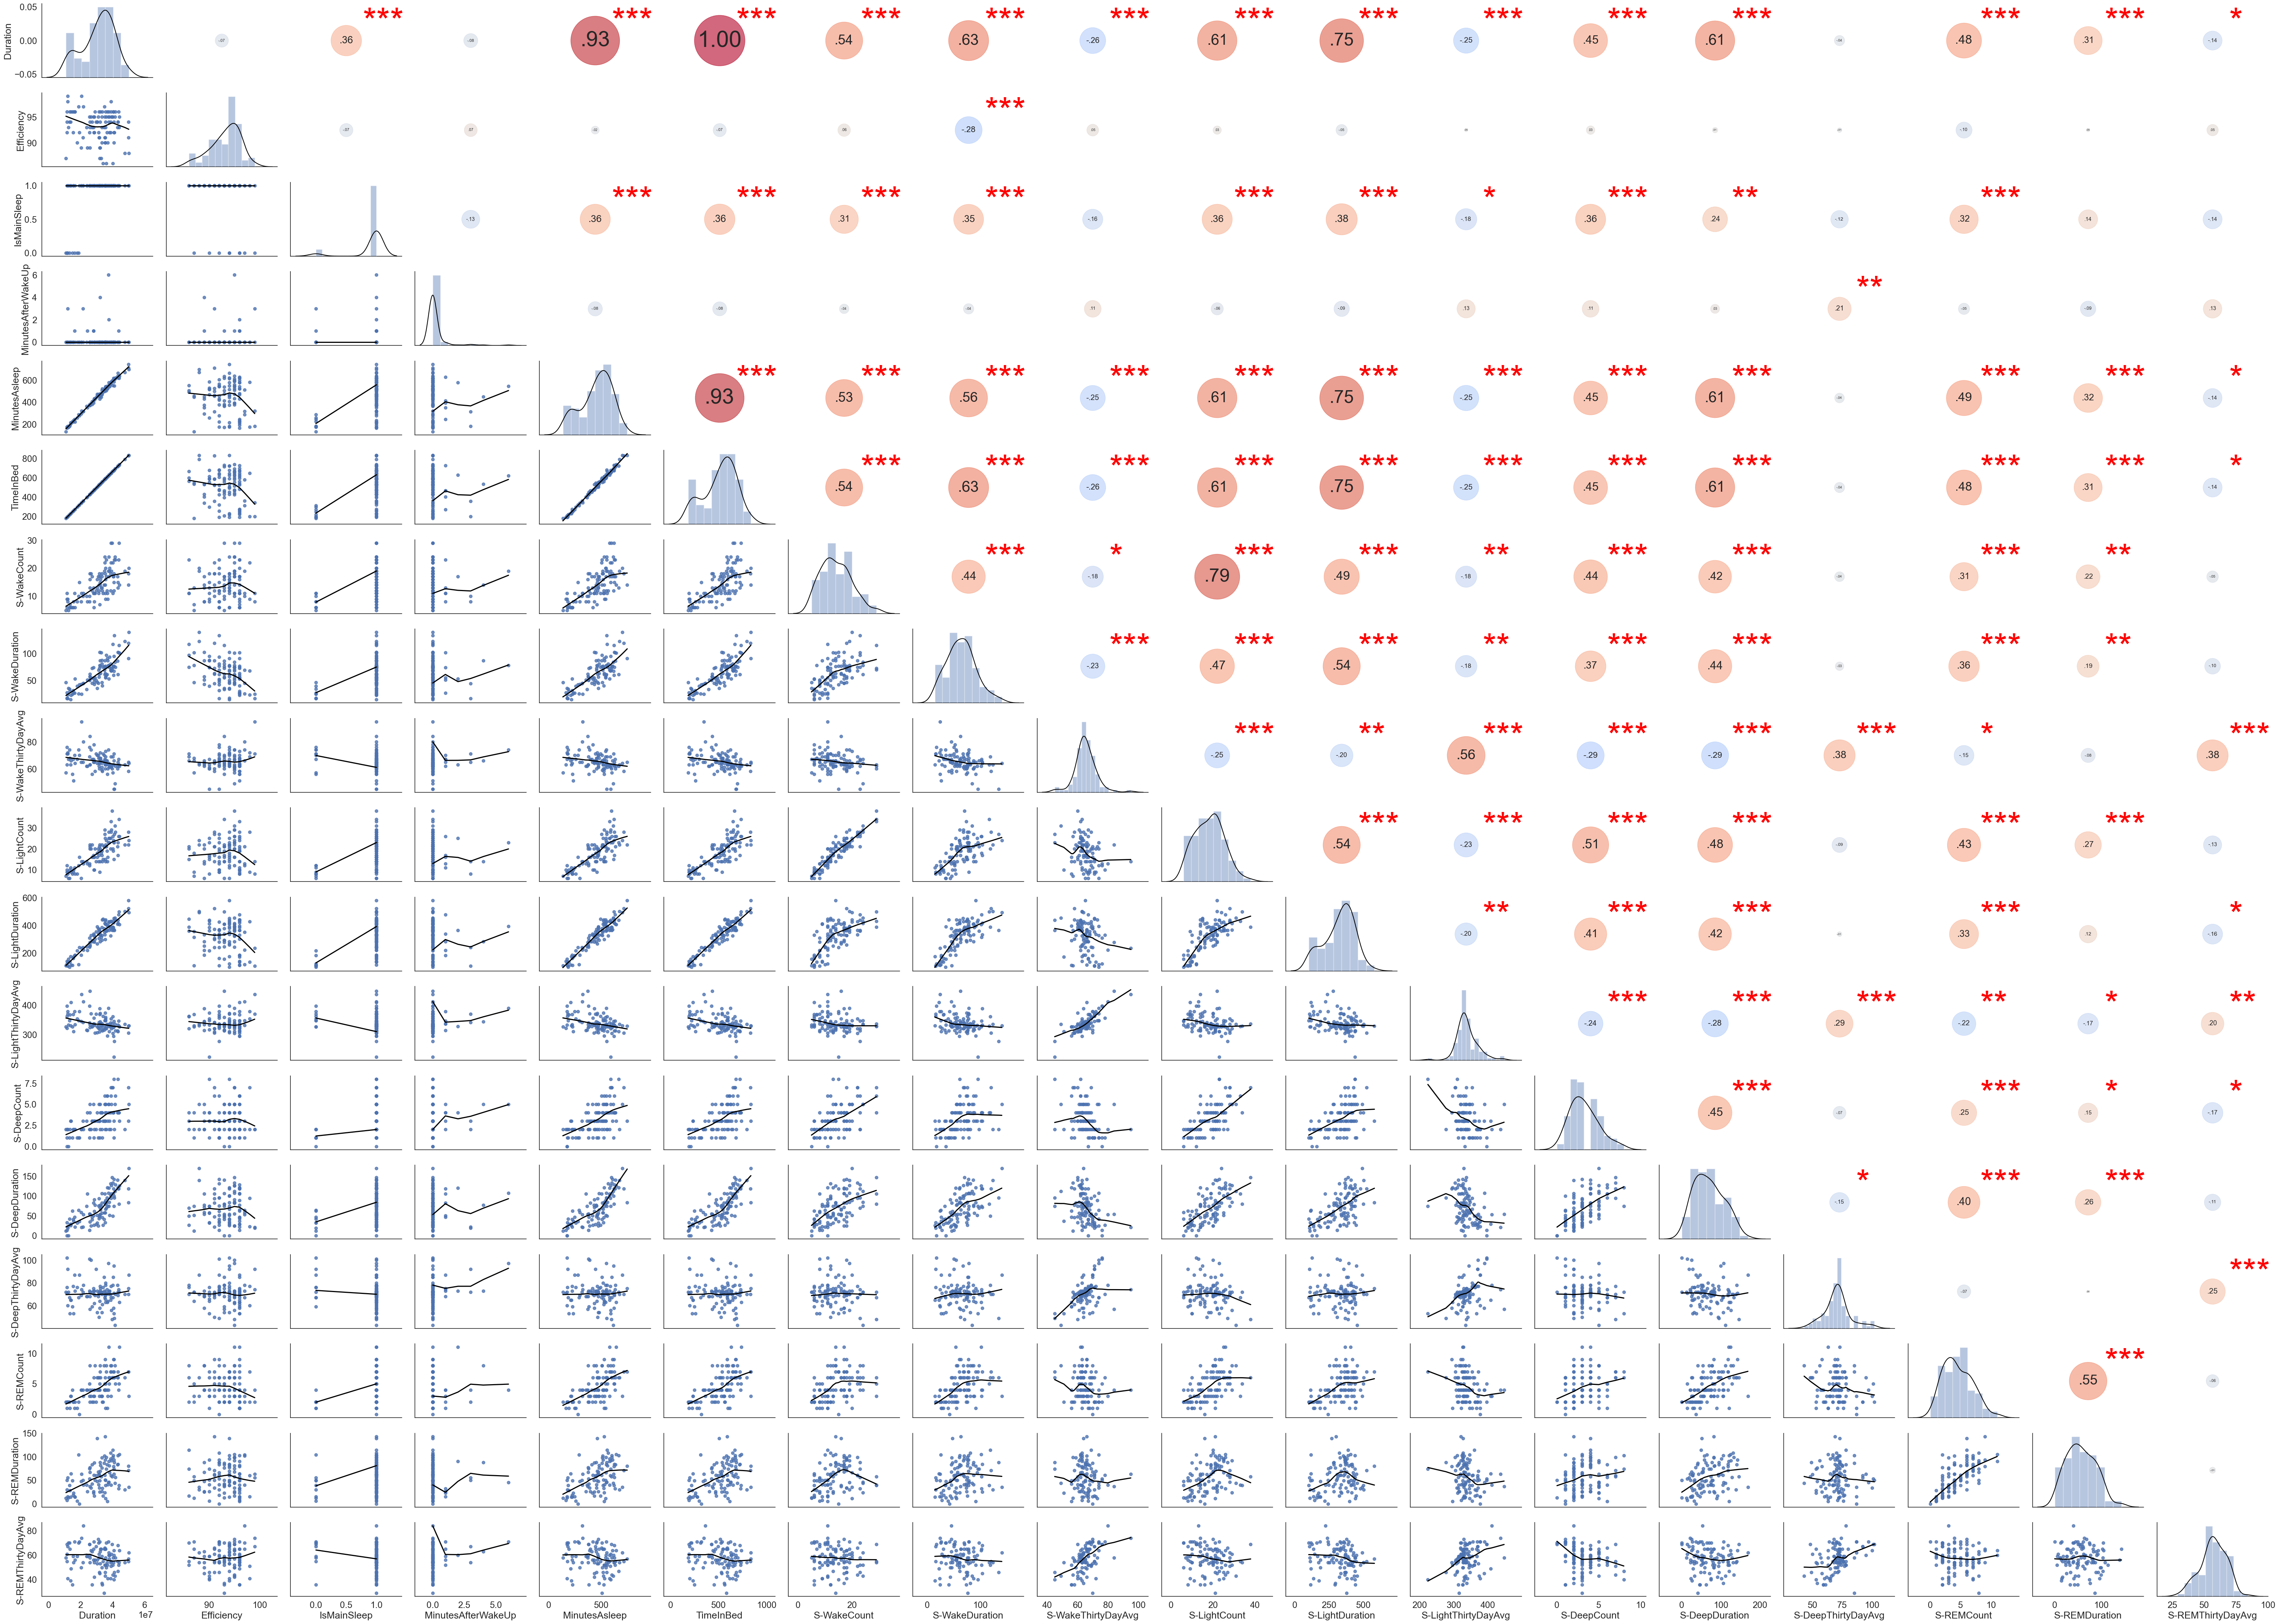

In [17]:
# let's see how well pairwise combinations of stages features correlate with each other
pt_sleep_wear_scatter_stages = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]].dropna()

plotcorr(pt_sleep_wear_scatter_stages)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_stages"))

plt.show()

In [18]:
# let's see if we can use general features to separate the data into high sleep and low sleep
pt_sleep_wear_scatter_clustered = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9]]

# let's Z score each column across all the instances in our dataset to deal with outliers better
pt_sleep_wear_scatter_clustered = pd.DataFrame(StandardScaler().fit_transform(pt_sleep_wear_scatter_clustered), columns = pt_sleep_wear_scatter_clustered.columns)

# we will use a hierarchical clustering algorithm (hierarchical DBSCAN)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(pt_sleep_wear_scatter_clustered)

pt_sleep_wear_scatter_clustered["cluster"] = cluster_labels.tolist()

In [19]:
# let's see the first 5 rows of the clustering results
pt_sleep_wear_scatter_clustered.head()

Duration  Efficiency  IsMainSleep  MinutesAfterWakeUp  MinutesAsleep  \
0 -0.210543    0.867638     0.649519           -0.244791      -0.243954   
1 -1.433703   -1.454570     0.649519           -0.244791      -1.445313   
2  0.947163   -0.293466     0.649519           -0.244791       1.054066   
3 -1.384613    0.577362    -1.539601           -0.244791      -1.371666   
4  1.090343   -1.164294     0.649519           -0.244791       0.989625   

   TimeInBed  cluster  
0  -0.210543        0  
1  -1.433703       -1  
2   0.947163        0  
3  -1.384613        1  
4   1.090343        0

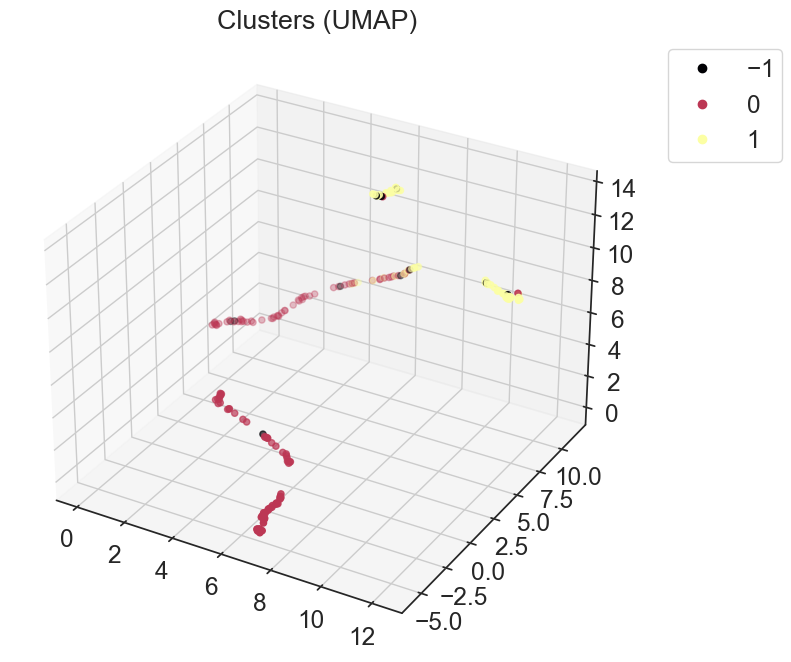

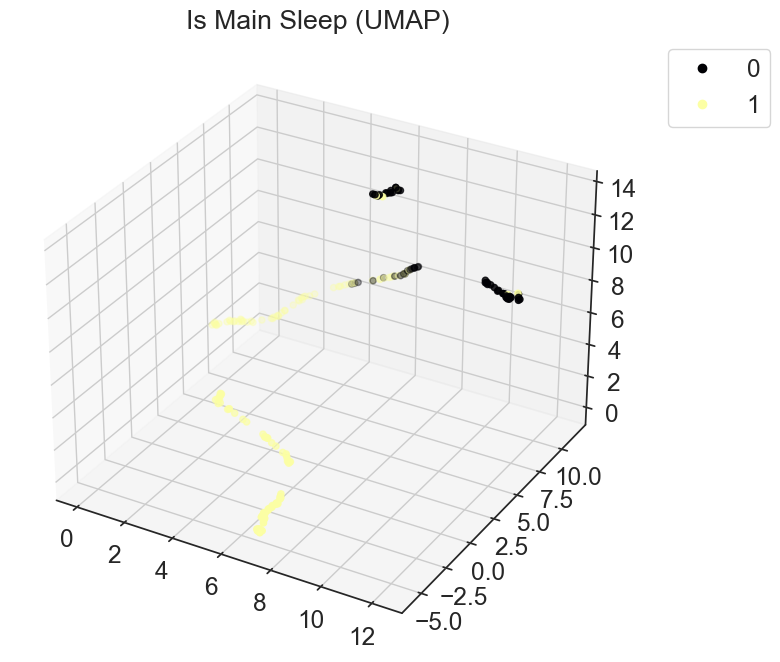

In [20]:
# let's visualize clusters and IsMainSleep in 3D using UMAP for nonlinear dimensionality reduction
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9]]

umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_3d = umap_3d.fit_transform(pt_sleep_wear_scatter)

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
sc = ax.scatter3D(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Clusters (UMAP)")

save_fig((pt_id + "_clusters_umap"))

# show plot
plt.show()

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
sc = ax.scatter3D(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=pt_sleep_wear["IsMainSleep"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Is Main Sleep (UMAP)")

save_fig((pt_id + "_is_main_sleep_umap"))

# show plot
plt.show()

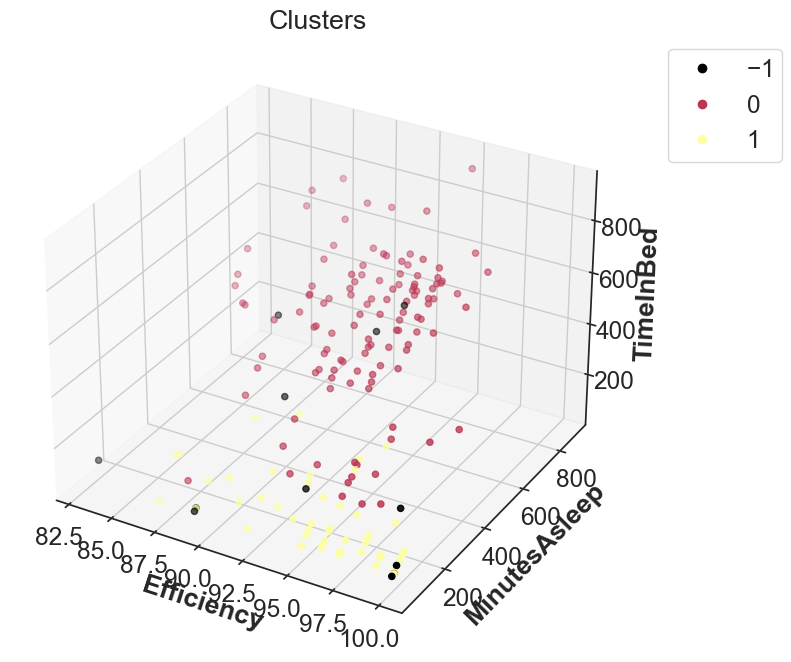

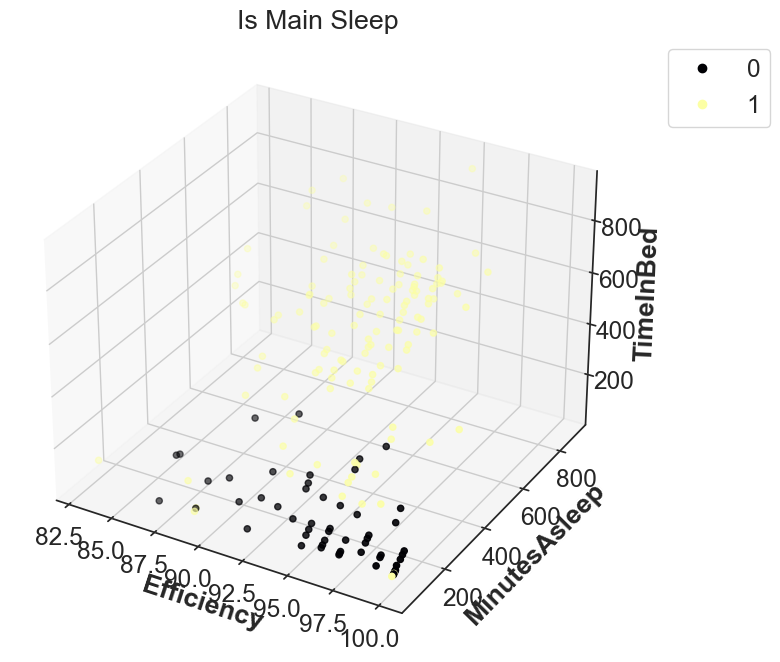

In [21]:
# let's visualize the clustering results in a 3D scatter plot with more concrete axes
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [3, 7, 9]].to_numpy()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Clusters")

ax.set_xlabel(pt_sleep_wear.columns[3], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[9], fontweight ='bold')

save_fig((pt_id + "_clusters_3D_efficiency"))

# show plot
plt.show()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear["IsMainSleep"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Is Main Sleep")

ax.set_xlabel(pt_sleep_wear.columns[3], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[9], fontweight ='bold')

save_fig((pt_id + "_is_main_sleep_3D_efficiency"))

# show plot
plt.show()

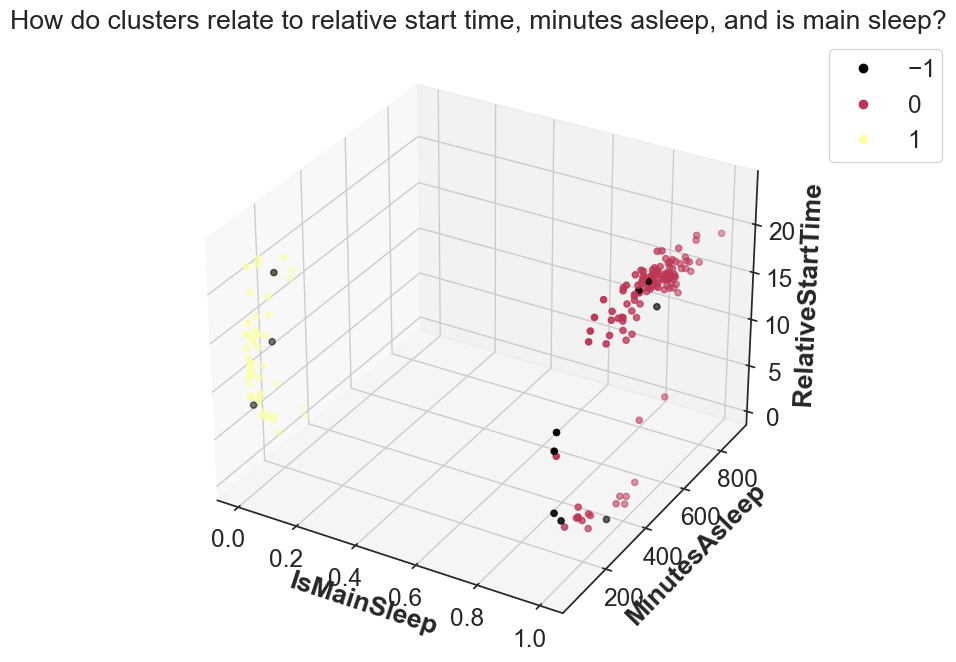

In [22]:
# How do clusters relate to relative start time, minutes asleep, and is main sleep?
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [4, 7, 31]].to_numpy()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("How do clusters relate to relative start time, minutes asleep, and is main sleep?")

ax.set_xlabel(pt_sleep_wear.columns[4], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[31], fontweight ='bold')

save_fig((pt_id + "_clusters_3D_relative_start_time"))

plt.show()

In [23]:
# let's calculate cluster fingerprints to see 
# if the clusters actually represent high and low sleep based on objective metrics
minClusterIndex = 0
maxClusterIndex = pt_sleep_wear_scatter_clustered["cluster"].max()

clusterFingerPrintsMeanZScore = pd.DataFrame()
clusterFingerPrintsStdZScore = pd.DataFrame()

for i in range(maxClusterIndex + 1):
    rowsOfInterest = pt_sleep_wear_scatter_clustered[pt_sleep_wear_scatter_clustered["cluster"] == i]
    
    clusterFingerPrintsMeanZScore["Cluster " + str(i)] = rowsOfInterest.loc[:, rowsOfInterest.columns != "cluster"].mean(axis=0)
    clusterFingerPrintsStdZScore["Cluster " + str(i)] = rowsOfInterest.loc[:, rowsOfInterest.columns != "cluster"].std(axis=0)

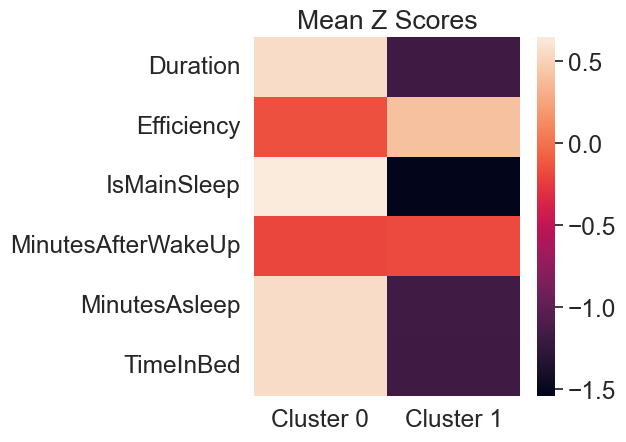

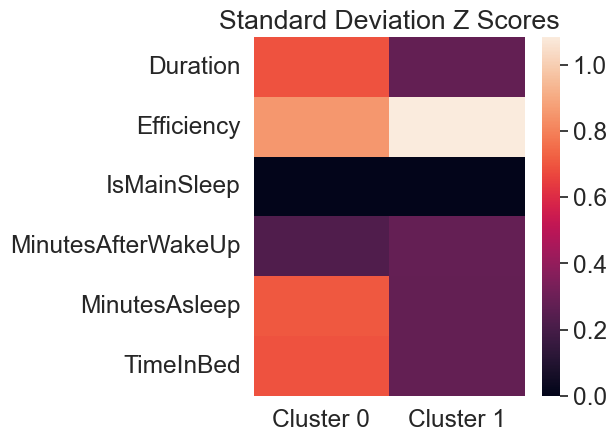

In [24]:
# plotting correlation heatmap
sns.heatmap(clusterFingerPrintsMeanZScore).set(title="Mean Z Scores")

save_fig((pt_id + "_cluster_fingerprints_mean_z_score"))

plt.show() 

sns.heatmap(clusterFingerPrintsStdZScore).set(title="Standard Deviation Z Scores")  

save_fig((pt_id + "_cluster_fingerprints_std_z_score"))

plt.show()